In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

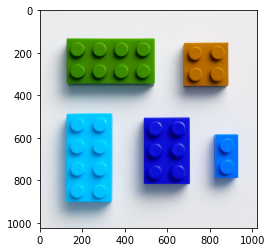

In [3]:
I = cv2.imread('lego_2.png')
I_rgb = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)

if I is None:
    print("Error: Could not load image. Check file path and format.")
    exit()
    
plt.imshow(I)
plt.show()

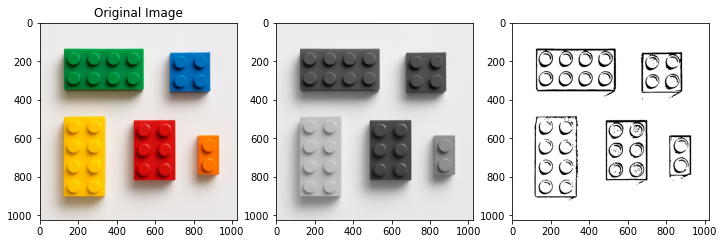

In [ ]:
#Grayscale for thresholding

I_gray = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
I_blur = cv2.GaussianBlur(I_gray, (5, 5), 0)  

B = cv2.adaptiveThreshold(
    I_blur, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    19, 2
)

#Morphology
kernel = np.ones((3,3), np.uint8)
B_clean = cv2.morphologyEx(B, cv2.MORPH_CLOSE, kernel)
B_clean = cv2.morphologyEx(B_clean, cv2.MORPH_OPEN, kernel)

# Invert so LEGO = white, background = black
B_inverted = cv2.bitwise_not(B_clean)


plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.subplot(1,3,2)
plt.imshow(I_gray, cmap='gray')

plt.subplot(1,3,3)
plt.imshow(B_inverted, cmap='gray')
plt.show()

In [ ]:
#test commit :)

In [ ]:
print('Test')